# Local Covid-19 Metrics

## Gather Datasets

In [17]:

# init
import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pandas import DataFrame

# set parameters
days_back = 365

# get content from web APIs
us = requests.get('https://covidtracking.com/api/v1/us/daily.json')
us = us.text
us = pd.read_json(us)

pa = requests.get('https://covidtracking.com/api/v1/states/pa/daily.json')
pa = pa.text
pa = pd.read_json(pa)

nj = requests.get('https://covidtracking.com/api/v1/states/nj/daily.json')
nj = nj.text
nj = pd.read_json(nj)

# we can only get the past 7 days for bucks county with this API
bucks_data = requests.get('https://localcoviddata.com/covid19/v1/cases/newYorkTimes?zipCode=19067&daysInPast=7')
bucks_data = bucks_data.text
bucks_data = pd.read_json(bucks_data)
bucks_data = bucks_data.counties[0].get("historicData")
bucks_data = DataFrame (bucks_data,columns=['date','deathCt','positiveCt'])
bucks_data['date'] = pd.to_datetime(pd.Series(bucks_data['date']), format="%Y-%m-%d")

# derive positive and death for bucks
diff = bucks_data[['deathCt','positiveCt']].diff(periods=-1)
bucks = bucks_data.join(diff, lsuffix='_caller', rsuffix='_other')
bucks = bucks.rename(columns={'deathCt_caller':'death_total'
                       ,'positiveCt_caller':'positive_total'
                       ,'deathCt_other':'death'
                       ,'positiveCt_other':'positive'})

# massage datasets

# make function for the covid tracking api since they are all the same
def clean_covidtracking_api_data(df):
    
    # get subset
    df = df[['date','positiveIncrease','totalTestResultsIncrease'
           ,'hospitalizedCurrently','death','deathIncrease','positive']]
    
    # Rename dataset columns
    df = df.rename(columns={'positiveIncrease':'positive'
                              ,'totalTestResultsIncrease': 'tests'
                              ,'hospitalizedCurrently': 'hospitalized'
                              ,'death': 'death_total'
                              ,'deathIncrease': 'death'
                              ,'positive': 'positive_total'})
    
    # Harmonize date column
    df['date'] = df['date'].astype(str)
    df['date'] = pd.to_datetime(pd.Series(df['date']), format="%Y%m%d")
    
    # Derived Columns
    # Positivity Rate
    positive = df.loc[:,['positive']].values[0:]
    tests = df.loc[:,['tests']].values[0:]
    df['pos_rate'] = positive / tests * 100

    # Death Rate
    deaths = df.loc[:,['death_total']].values[0:]
    positive = df.loc[:,['positive_total']].values[0:]
    df['death_rate'] = (deaths / positive) * 100
    df['death_rate_est'] = (deaths / (positive * 10)) * 100
    
    return df

# fix individual files
pa = clean_covidtracking_api_data(pa)
nj = clean_covidtracking_api_data(nj)
us = clean_covidtracking_api_data(us)

# Make compact summary dataset
a = us[['date','positive','pos_rate','hospitalized']]
b = pa[['date','positive','pos_rate','hospitalized']]
c = nj[['date','positive','pos_rate','hospitalized']]
a.set_index('date')
b.set_index('date')
c.set_index('date')

summary = c.join(a.join(b, lsuffix='_us', rsuffix='_pa'), rsuffix='_nj')


# get subset
summary = summary[['date'
                   ,'positive_us','pos_rate_us','hospitalized_us'
                   ,'positive_pa','pos_rate_pa','hospitalized_pa'
                   ,'positive','pos_rate','hospitalized']]

summary = summary.rename(columns={'positive_us':'pos_us'
                                 ,'positive_pa':'pos_pa'
                                 ,'positive':'pos_nj'
                                 ,'hospitalized_us':'hosp_us'
                                 ,'hospitalized_pa':'hosp_pa'
                                 ,'hospitalized':'hosp_nj'})


# Bucks death rate as of August 8, 2020
bucks_case_rate = 7118/626370*100000




## NOTES

Facts: 
- NJ has about 8.8 million people
- PA has about 12.5 million people
- Bucks County has 626,370 people
- WHO recommends opening schools for in person learning when your area has a positivity rate of no more than 5% for seven days
- face-to-face instruction requires the county rate of new cases per 100,000 people to be fewer than 100 for the last 14 days (source, WHO, Gupta?)

By mid-August
- PA had 953 cases per 100,000 people
- NY had 2,157 cases per 100,000 people
- NJ had 2,072 cases per 100,000 people
- Bucks had 1,136 cases per 100,000 people

In late summer:
- Bucks had an average of less than one death per day
- Bucks had about 30 new positive cases per day
- PA had an average positivity rate of 5.5%
- NJ had an average positivity rate of about 2%
- PA had a confirmed infection rate of 0.954%
- Bucks had a confirmed infection rate of 0.0114%

* NOTE experts believe that at least 10% of the population has an undiagnosed case of Covid-19. So if bucks has a confirmed infection rate of 0.0114 then we can assume that 0.114% of the Bucks County has been infected.

## PA and NJ Summary

In [18]:
summary.head(14)

,date,pos_us,pos_rate_us,hosp_us,pos_pa,pos_rate_pa,hosp_pa,pos_nj,pos_rate,hosp_nj
0,2020-10-24,82668,6.829261,41882.0,2043.0,12.586249,1087.0,1909,100.000000,886.0
1,2020-10-23,83010,6.484482,41485.0,2219.0,12.322301,1068.0,1045,2.588364,874.0
2,2020-10-22,75248,6.665368,41010.0,2063.0,10.522289,1042.0,1162,3.469796,852.0
3,2020-10-21,58606,6.653407,40271.0,1425.0,10.696592,966.0,1030,3.573535,844.0
4,2020-10-20,60664,6.670875,39230.0,1557.0,11.768707,918.0,988,5.615232,781.0
5,2020-10-19,57148,4.749794,37826.0,1103.0,8.882268,870.0,1192,1.512038,758.0
6,2020-10-18,48922,4.979673,36437.0,1269.0,9.019190,841.0,1275,41.463415,732.0
7,2020-10-17,57943,4.846572,37359.0,1857.0,9.950169,847.0,934,2.715353,759.0
8,2020-10-16,68124,5.959266,37336.0,1566.0,10.160254,830.0,810,2.609368,728.0
9,2020-10-15,63172,6.198596,37308.0,1598.0,9.946471,799.0,971,2.899373,733.0


## Bucks Summary

In [19]:
bucks.head()

,date,death_total,positive_total,death,positive
0,2020-10-23,624,9848,1.0,84.0
1,2020-10-22,623,9764,0.0,55.0
2,2020-10-21,623,9709,0.0,38.0
3,2020-10-20,623,9671,0.0,34.0
4,2020-10-19,623,9637,0.0,38.0


In [20]:

# change political entity dataset to select visualizations
# (stopgap for now until we have better organized data)

political_entity = pa


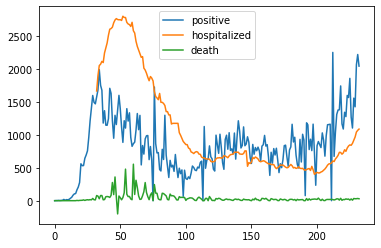

In [21]:

subset_df = political_entity.loc[:,['positive']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'positive')

subset_df = political_entity.loc[:,['hospitalized']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'hospitalized')

subset_df = political_entity.loc[:,['death']]
arr = subset_df[:].to_numpy()
reversed_arr = arr[::-1]
reversed_arr = reversed_arr[-days_back:]
plt.plot(reversed_arr[0:], label = 'death')

plt.legend()
plt.show()


# References

- https://www-doh.state.nj.us/doh-shad/view/sharedstatic/CrudeDeathRate.pdf
- https://www.cnn.com/resources/coronavirus-information/19067
